Установим все необходимы библиотеки

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns
!pip install kneed
from kneed import KneeLocator

In [3]:
#Зададим параметры нашего датасета
n_samples = 3508
random_state = 150
X_1, y_1 = make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)

#Создадим второй набор данных которые будут распределены анизотропно
random_state = 150
X_2, y_2 = make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X_2, transformation)
aniso = (X_aniso, y_2)

In [ ]:
!pip install umap-learn

Подгружаем датасет и производим нормализацию данных (приводим все числовые переменные к диапазону от 0 до 1)

In [5]:
data = pd.read_excel('cluster.xlsx')
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
X = sc.fit_transform(data)
import umap.umap_ as umap
reducer = umap.UMAP()
X = reducer.fit_transform(X)

In [ ]:
X.shape

(3508, 2)

Посмотрим как на наших данных работает метод ближайших соседей

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

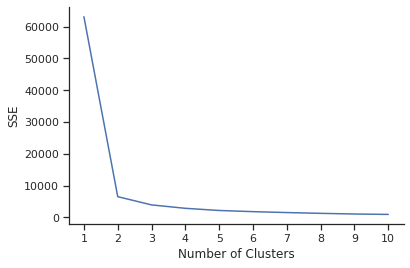

In [ ]:
# K calculation method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_aniso)
    sse.append(kmeans.inertia_)
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

На полученом графике явно определилось два кластера. Попробуем их визуализировать.

In [ ]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing")

kl.elbow

2

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


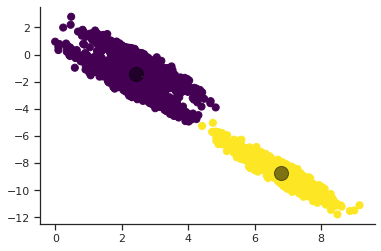

In [ ]:
n_clusters=kl.elbow  
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X_aniso)
y_aniso = kmeans.predict(X_aniso)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_aniso, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.show()

На графике видно что алгоритм определил наличие двух центроидов, но можно заметить что на самом деле кластеров скорее всего 3. Поэтому стоит попробовать другие алгоритмы.

In [ ]:
kmeans.n_iter_

2

In [ ]:
#Выведем координаты центроидов 
kmeans.cluster_centers_

array([[ 2.43807863, -1.42329412],
       [ 6.80910316, -8.7347731 ]])

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


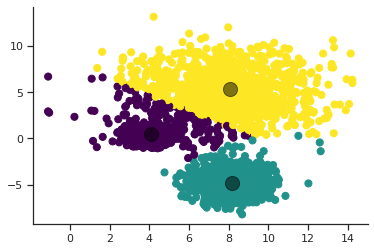

In [ ]:
n_clusters=kl.elbow  
#Попробуем посмотреть как алгоритм справится с отделением двух близко лежащих кластеров
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_1)
y_1 = kmeans.predict(X_1)
plt.scatter(X_1[:, 0], X_1[:, 1], c=y_1, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.show()

На картинке видно что алгоритм выделил третий кластер, но точность его работы не очень высокая.

Попробуем Сбалансированное итеративное сокращение и кластеризацию иерархий

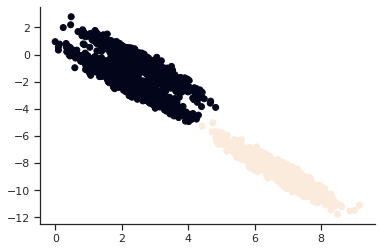

In [ ]:
model = Birch(branching_factor = 50, n_clusters = None, threshold = 1.5)
model.fit(X_aniso)
pred = model.predict(X_aniso)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c = pred)


Модель все еще выделяет 2 кластера, можем заметить что в 'черном' кластере более явно наблюдается подкластер (более явно чем в методе ближайших соседей) 

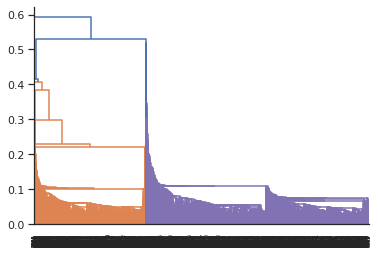

In [ ]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(X_aniso, 'single')
hierarchy.dendrogram(
    Z,
)
plt.show()

На этом графике видно что кластеров 3, но алгоритм не выделяет последний кластер и считает его частью второго кластера.

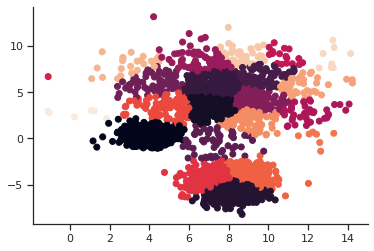

In [ ]:
model = Birch(branching_factor = 50, n_clusters = None, threshold = 1.5)
model.fit(X_1)
pred = model.predict(X_1)
plt.scatter(X_1[:, 0], X_1[:, 1], c = pred)

На графике выше видно что алгоритм плохо справляется в не анизотропном пространстве 

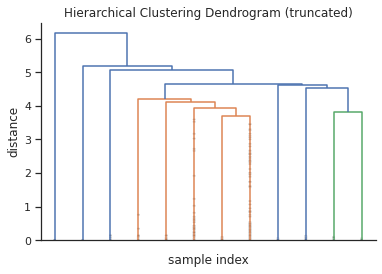

In [ ]:
plt.figure()
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
hierarchy.dendrogram(
    Z,
    truncate_mode='lastp',  
    p=12,                   
    show_leaf_counts=False, 
    show_contracted=True,  
plt.show()

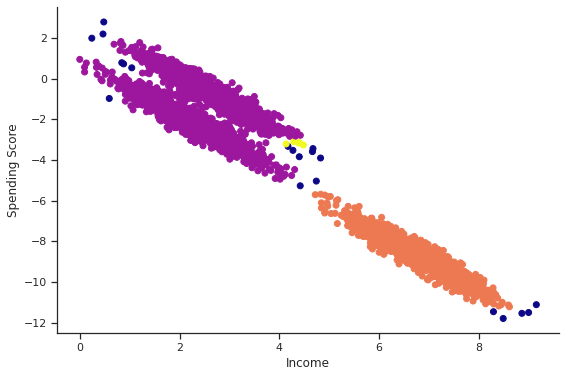

In [ ]:
# Попробуем алгоритм Density-based spatial clustering of applications with noise
dbscan = DBSCAN(eps = 0.25, min_samples = 4).fit(X_aniso) 
labels = dbscan.labels_ 

plt.scatter(X_aniso[:, 0], X_aniso[:,1], c = labels, cmap= "plasma") 
plt.xlabel("Income") 
plt.ylabel("Spending Score") 
plt.show() 

На графике видиим что алгоритм хорошо справился с поиском outlires но 3 кластер все еще выделить не может

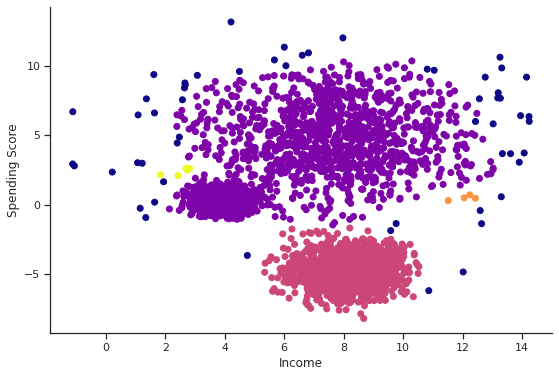

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.6, min_samples = 4).fit(X_1) 
labels = dbscan.labels_ 

plt.scatter(X_1[:, 0], X_1[:,1], c = labels, cmap= "plasma") 
plt.xlabel("Income") 
plt.ylabel("Spending Score") 
plt.show()

На графике выше можно заметить что внутри фиолетового класса присутсвует явный центр тяжести, но алгоритм отказывается выделять его в отдельный кластер

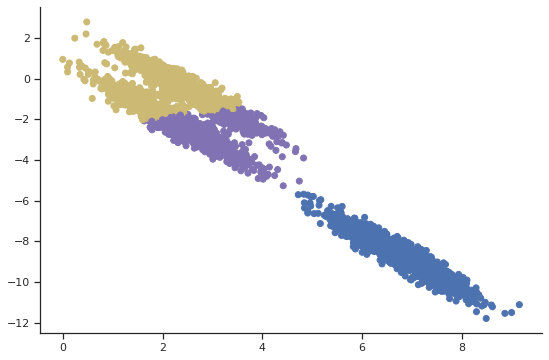

In [ ]:
# Посмотрим что предложит SpectralClustering model
spectral_model_rbf = SpectralClustering(n_clusters = 3, affinity ='rbf')

labels_rbf = spectral_model_rbf.fit_predict(X_aniso)


colours = {}
colours[0] = 'b'
colours[1] = 'y'
colours[2] = 'm'


cvec = [colours[label] for label in labels_rbf]

plt.scatter(X_aniso[:,0], X_aniso[:,1], c = cvec)
plt.show()

Модель выделила 3 кластера но к сожалению не совсем верно, посмотрим как модель справиться в первоначальном пространстве 

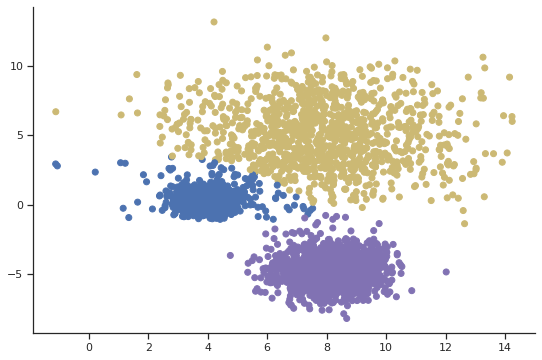

In [ ]:

spectral_model_rbf = SpectralClustering(n_clusters = 3, affinity ='rbf')

labels_rbf = spectral_model_rbf.fit_predict(X_1)


colours = {}
colours[0] = 'b'
colours[1] = 'y'
colours[2] = 'm'


cvec = [colours[label] for label in labels_rbf]

plt.scatter(X_1[:,0], X_1[:,1], c = cvec)
plt.show()

В изначальном пространстве алгоритм справился лучше и верно выделил все три клатстера. Хотя пограничные значения все еще определяются не совсем точно.

In [6]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariances_, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariances_.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariances_)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariances_)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    sns.set_style("white")
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.1 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

Попробуем последний вариант - Гауссовскую смесь.

<ipython-input-6-0cebb74b0332>:14: RuntimeWarning: invalid value encountered in sqrt
  width, height = 2 * np.sqrt(covariances_)
<ipython-input-6-0cebb74b0332>:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


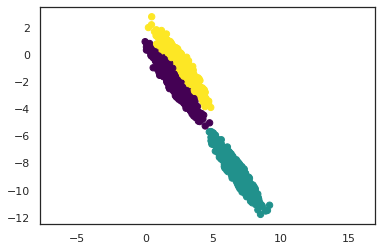

In [7]:
gmm = GaussianMixture(n_components=3, covariance_type='tied').fit(X_aniso)
labels = gmm.predict(X_aniso)
plot_gmm(gmm, X_aniso)

На графике явно видны 3 кластера.

In [9]:
lb = pd.DataFrame(labels)
lb.to_excel('labels.xlsx')

Посмотрим справится ли гауссовская смесь в изнальныом пространстве

<ipython-input-6-0cebb74b0332>:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


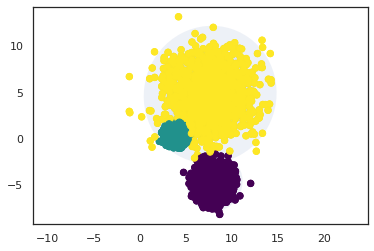

In [12]:
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(X_1)
labels = gmm.predict(X_1)
plt.scatter(X_1[:, 0], X_1[:, 1], c=labels, s=40, cmap='viridis');
plot_gmm(gmm, X_1)

И в изначальном пространстве алгоритм успешно смог выделить все кластеры

Из всех использованных методов кластеризации на наших данных лучше всего себя показала модель GaussianMixture. Остальные модели не были столь успешны и не смогли выделить 3 кластера хотя на всех графиках отчетливо видны 3 центра тяжести.